# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.applications import ResNet50V2
from nltk.translate.bleu_score import sentence_bleu
import copy

# Image Preprocessing

### Load Images

In [2]:
images_path = 'Images/'
images = glob(images_path+'*.jpg')
print("No. of Images: ",len(images))
print("List View: ",images[:5])


No. of Images:  8091
List View:  ['Images\\1000268201_693b08cb0e.jpg', 'Images\\1001773457_577c3a7d70.jpg', 'Images\\1002674143_1b742ab4b8.jpg', 'Images\\1003163366_44323f5815.jpg', 'Images\\1007129816_e794419615.jpg']


### View Sample Images

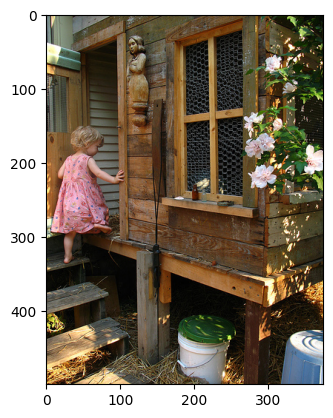

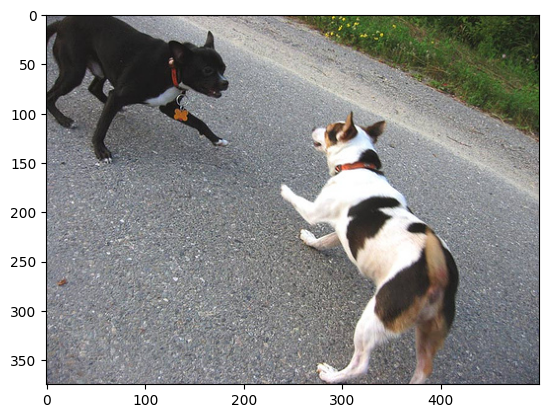

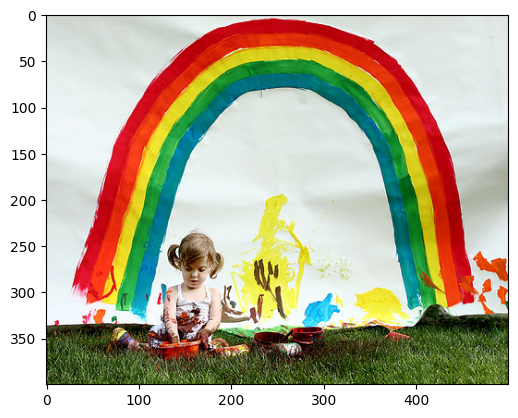

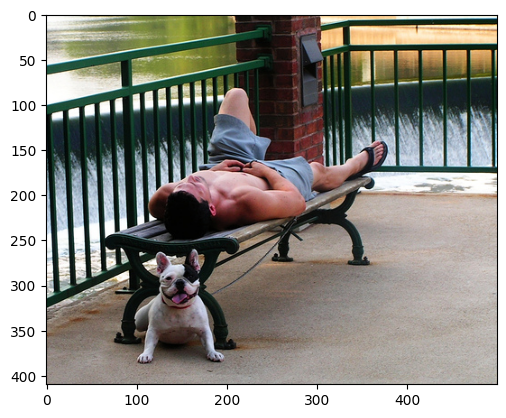

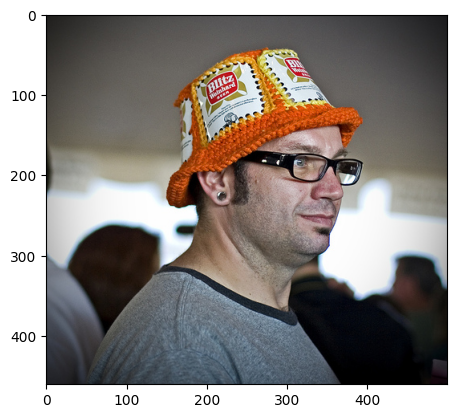

In [3]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)


# CNN Model for Feature Extraction

### Load Model

In [4]:
base_model = ResNet50V2(include_top=True)
base_model.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Configure Model

In [5]:
from keras.models import Model
last = base_model.layers[-2].output
model1 = Model(inputs=base_model.input, outputs=last)
model1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Feature Extraction

In [ ]:
images_features = {}
count = 0
TOTAL_NO_OF_IMAGES = len(images)
TRAIN = int(0.19*TOTAL_NO_OF_IMAGES)
TEST = TOTAL_NO_OF_IMAGES - TRAIN
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img = img.reshape(1, 224, 224, 3)
    pred = model1.predict(img).reshape(2048,)

    img_name = i.split('/')[-1]

    images_features[img_name] = pred

    count += 1

    if count > TRAIN:
        break

print("Number of Features: ",len(images_features))


# Text Preprocessing

### Load Captions

In [ ]:
caption_path = 'captions.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')
print("No. of Captions: ",len(captions))
print(captions[1].split(',')[1])


### Map Images to Captions

In [ ]:
captions_dict = {}
reference_dict = copy.deepcopy(captions_dict)
for i in captions:
    try:
        img_name = 'Images\\'+i.split(',')[0]
        caption = i.split(',')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]

            else:
                captions_dict[img_name].append(caption)

    except:
        pass

reference_dict = copy.deepcopy(captions_dict)
len(captions_dict)

In [ ]:
for k,v in reference_dict.items():
    for x in range(len(reference_dict[k])):
        reference_dict[k][x] = reference_dict[k][x].split()
# reference_dict['Images\\1000268201_693b08cb0e.jpg']

### Visualize Images with Captions

In [ ]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()

    # img_name = 'Images/' + k
    img_name = k

    img = cv2.imread(img_name)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name][-1])
    plt.imshow(img)

    break


### Preprocess Captions

In [ ]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

for k, v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

### Create Vocabulary

In [ ]:
count_words = {}
for k, vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

print("Vocab Size: ",len(count_words))


### Converting Vocabulary to Integer Vocabulary

In [ ]:
THRESH = -1
count = 1
new_dict = {}
for k, v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1

print("Vocab Size: ",len(new_dict))

In [ ]:
print("Before: ",captions_dict['Images\\1000268201_693b08cb0e.jpg'])
new_dict['<OUT>'] = len(new_dict)
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])

        captions_dict[k][vv.index(v)] = encoded

print("After: ",captions_dict['Images\\1000268201_693b08cb0e.jpg'])

# Generator Function

In [ ]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)

print("Max Length of a Word: ",MAX_LEN)

Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0

    X = []
    y_in = []
    y_out = []

    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq = [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(
                    in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)

    return X, y_in, y_out


In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)
len(X), len(y_in), len(y_out)


In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')


In [ ]:
X.shape, y_in.shape, y_out.shape


In [ ]:
X[1510]


In [ ]:
y_in[2]


# RNN Model for Training and Prediction

### Imports

In [ ]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dense, LSTM, TimeDistributed, Embedding, Activation, RepeatVector, Concatenate
from keras.models import Sequential, Model

### Configure Model

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size,output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs=out)

# model.load_weights("mine_model_weights.h5")
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop', metrics=['accuracy'])
model.summary()


### Plot Model

In [ ]:
plot_model(model,show_shapes=True)

### Fit Model

In [ ]:
EPOCH = 20
model.fit([X, y_in], y_out, batch_size=512, epochs=EPOCH)


### Save Model

In [ ]:
inv_dict = {v: k for k, v in new_dict.items()} # For Prediction
model.save('model_'+str(EPOCH)+'E.h5')
model.save_weights('mine_model_weights_'+str(EPOCH)+'E.h5')
np.save('vocab.npy', new_dict) # type: ignore

# Predictions

In [ ]:
def getImage(x):

    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (299, 299))

    test_img = np.reshape(test_img, (1, 299, 299, 3))

    return test_img


In [ ]:
bleu_scores = []
for i in range(5):
# for i in range(TEST):
#     no = i
    no = np.random.randint(1500, 7000, (1, 1))[0, 0]
    test_feature = model1.predict(getImage(no)).reshape(1, 2048)

    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25: # Assuming number of words in a caption is not more than 25
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)

        prediction = np.argmax(model.predict([test_feature, encoded])) # Predicting next word which has Higher Probability

        sampled_word = inv_dict[prediction]

        if sampled_word == 'endofseq':
            break

        caption = caption + ' ' + sampled_word        

        text_inp.append(sampled_word)
    
    bleu_scores.append(sentence_bleu(reference_dict[test_img_path],caption.split()))
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

In [ ]:
bleu_scores